# Hotel Cancel Culture - Time Series Modeling and Forecasting

---

**Forecasting Cancellations**

> * **Goal:** Forecast cancellations for the given hotel data
> * **Why:** Predictions only work on preexisting reservations
    * *How can we forecast occupancy without depending on preexisting reservations?*
> * **How:** Using probabilities generated from prior classification modeling to forecast future cancellations

---

# Notes

---

**9/22/21**

- Determined it's too complicated to use the probabilities for TSM for now
    - instead resampled data and generated the average daily cancellations

- Determined "m" via seasonal decomp (also, think about the nature of the data - patterns emerge over the course of a week and repeat).


- Took note of several issues with workflow function
    - show_vis inconsistent
    - results are in a deeply nested dictionary
        - simplify?
    - no progress-tracking print statements

---

**Updated 9/24**

- [X] Refactored functions
    - Can set plot labels
    - Can set date for t/t split threshold
- [ ] Simplify nested dictionary
- [X] Update title for T/T split
- [ ] `model.plot_diagnostics()` needs `plt.tight_layout()`
- [X] Forecast results poor past 1 month-ish
    - *Any way to improve?*
    
---

**Update 9/28**

 - [X] Attempted additional train/test split thresholds to improve results
 - [X] Determined 90-day threshold best
     - Minor differences with shorter time frames
     - Shorter time frames limit usefulness of forecast
         - Fewer departments can make use of the data
 - [ ] Add holidays as exogenous feature to improve modeling
 - [ ] Perform vector autoregression w/ additional features
 

[Return to workflow](#return)

# Imports

In [1]:
## JNB tool to reload functions when called
%load_ext autoreload
%autoreload 2

In [2]:
## Data Handling
import pandas as pd
import numpy as np

## Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

## Time Series Modeling
import statsmodels
import statsmodels.tsa.api as tsa
from statsmodels.tsa.seasonal import seasonal_decompose

import pmdarima as pmd
from pmdarima.arima import ndiffs
from pmdarima.arima import nsdiffs

## Custom-made Functions
from bmc_functions import eda
from bmc_functions import time_series_modeling as tsm

In [3]:
## Settings
%matplotlib inline
plt.style.use('seaborn-talk')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('max_rows', 100)

## Reminder on how to use ihelp function

In [4]:
# import fsds as fs

In [5]:
# fs.ihelp(tsm.ts_split, file_location=True)

# Reading Data

---

**Reading Data and Setting the Datetime Index**

> I will import the data I cleaned and prepped in advance for my modeling processes.
>
> I created an `arrival_date` column during the prep process containing the arrival date as a datetime object. Using this feature, I will reset my index to enable the time series modeling.

---

In [6]:
## Reading data and setting DT index
source = './data/data_probs.pickle'
data = pd.read_pickle(source, compression = "gzip")
data = data.set_index(data['arrival_date'])
data

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,agent_group,arrival_date,arrival_day,cxl_probability
arrival_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-07-01,Resort Hotel,0,342,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,0,0,0,C,3,No Deposit,0,Transient,0.00,0,0,2015-07-01,999,2015-07-01,Wednesday,0.04
2015-07-01,Resort Hotel,0,737,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,0,0,0,C,4,No Deposit,0,Transient,0.00,0,0,2015-07-01,999,2015-07-01,Wednesday,0.01
2015-07-01,Resort Hotel,0,7,July,27,1,0,1,1,0.00,0,BB,GBR,Direct,0,0,0,A,0,No Deposit,0,Transient,75.00,0,0,2015-07-02,999,2015-07-01,Wednesday,0.01
2015-07-01,Resort Hotel,0,13,July,27,1,0,1,1,0.00,0,BB,GBR,Corporate,0,0,0,A,0,No Deposit,0,Transient,75.00,0,0,2015-07-02,999,2015-07-01,Wednesday,0.02
2015-07-01,Resort Hotel,0,14,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,0,0,0,A,0,No Deposit,0,Transient,98.00,0,1,2015-07-03,240,2015-07-01,Wednesday,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-30,City Hotel,0,23,August,35,30,2,5,2,0.00,0,BB,BEL,Offline TA/TO,0,0,0,A,0,No Deposit,0,Transient,96.14,0,0,2017-09-06,999,2017-08-30,Wednesday,0.01
2017-08-31,City Hotel,0,102,August,35,31,2,5,3,0.00,0,BB,FRA,Online TA,0,0,0,E,0,No Deposit,0,Transient,225.43,0,2,2017-09-07,9,2017-08-31,Thursday,0.46
2017-08-31,City Hotel,0,34,August,35,31,2,5,2,0.00,0,BB,DEU,Online TA,0,0,0,D,0,No Deposit,0,Transient,157.71,0,4,2017-09-07,9,2017-08-31,Thursday,0.13


# **Resampling**

---

**Resampling the Arrival Dates**

> My dataset includes multiple reservations per day, which makes sense, but also impairs the modeling process.
>
> **I will resample the data as daily averages for the modeling and forecasting process.**
* *Daily resampling* allows me to view the data for all reservations for a given day.
* *Computing the average cancellations* provides a normalized value allowing for easy comparisons between dates (without having to consider other features, such as occupancy, demand, etc.).

arrival_date
2015-07-01   0.16
2015-07-02   0.61
2015-07-03   0.34
2015-07-04   0.49
2015-07-05   0.30
             ... 
2017-08-27   0.28
2017-08-28   0.30
2017-08-29   0.35
2017-08-30   0.30
2017-08-31   0.34
Freq: D, Name: is_canceled, Length: 793, dtype: float64

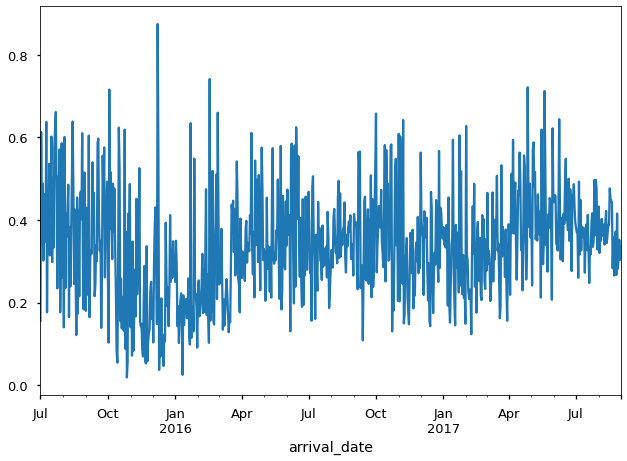

In [32]:
## Resampling for average daily cancellations
ts_avg = data['is_canceled'].resample('D').mean()
display(ts_avg)
ts_avg.plot();

In [33]:
## Subsetting data from 2016-17
ts_avg = ts_avg.loc["2016":'2017']
ts_avg

arrival_date
2016-01-01   0.25
2016-01-02   0.35
2016-01-03   0.29
2016-01-04   0.14
2016-01-05   0.19
             ... 
2017-08-27   0.28
2017-08-28   0.30
2017-08-29   0.35
2017-08-30   0.30
2017-08-31   0.34
Freq: D, Name: is_canceled, Length: 609, dtype: float64

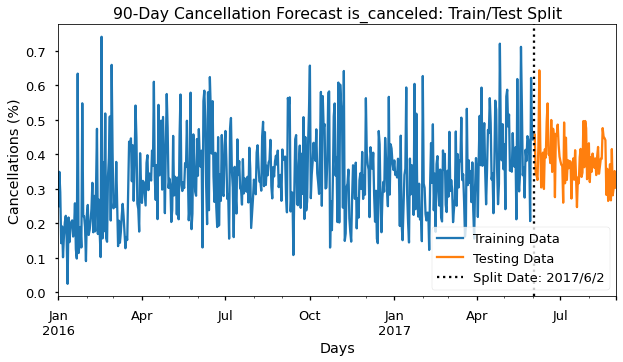

In [34]:
## Creating train/test split
split_dict = tsm.train_test_split(ts_avg, -90, xlabel="Days",
                                  ylabel="Cancellations (%)",
                                  title = "90-Day Cancellation Forecast");

In [35]:
## Inspecting results
split_dict['train']

arrival_date
2016-01-01   0.25
2016-01-02   0.35
2016-01-03   0.29
2016-01-04   0.14
2016-01-05   0.19
             ... 
2017-05-29   0.21
2017-05-30   0.62
2017-05-31   0.45
2017-06-01   0.44
2017-06-02   0.46
Freq: D, Name: is_canceled, Length: 519, dtype: float64

# **Seasonal Decomposition**

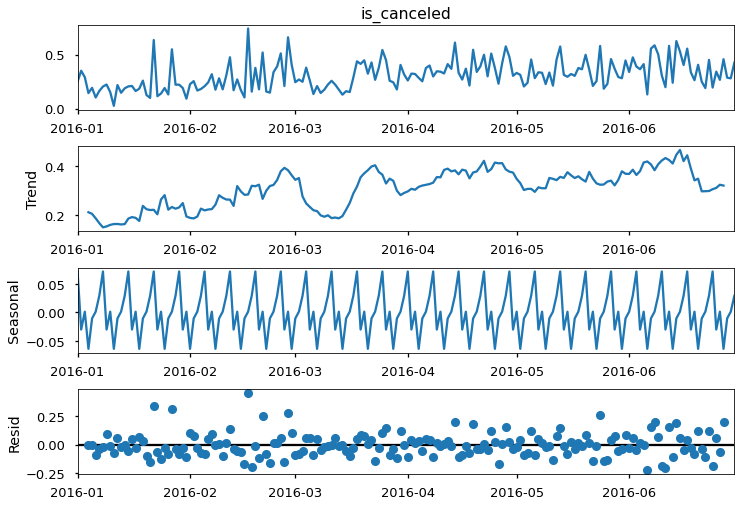

In [36]:
## Performing seasonal decomp to determine seasonality for modeling
decomp = tsa.seasonal_decompose(split_dict['train'].loc['01-2016':'06-2016'])
# decomp.seasonal.plot(figsize = (15,4));
decomp.plot();

---

**Seasonality**

> Based on the results of the seasonal decomposition, I see there is a weekly seasonality (there are four peaks/valleys per month). This matches up with my expectation that there would be regular stay/cancel patterns based on the day of the week a reservation is due to arrive.
>
> Now that I determined the seasonality, I will use it as an argument in my workflow function (created from a prior time series modeling project).

---

# **Full Workflow**

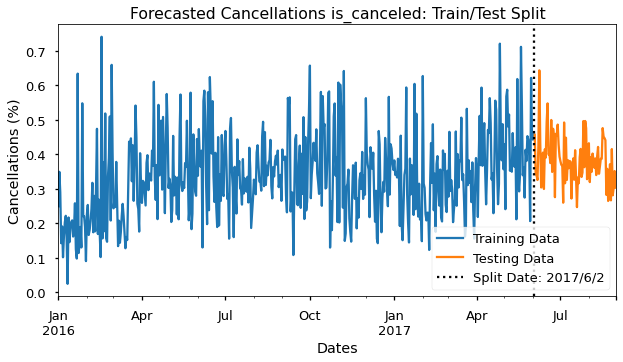

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  519
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood                 388.049
Date:                           Tue, 28 Sep 2021   AIC                           -766.098
Time:                                   15:02:21   BIC                           -744.849
Sample:                                        0   HQIC                          -757.773
                                           - 519                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.367e-05   4.29e-05      0.785      0.433   -5.04e-05       0.000
ma.L1         -0.9491      0.016    -57.655      0.000      -0.981      -0.917
ar.S.L7        0.9216      0.070     13.152      0.000       0.784       1.059
ma.S.L7       -0.8775      0.093     -9.462      0.000      -1.059      -0.696
sigma2         0.0132      0.001     17.712      0.000       0.012       0.015
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                72.20
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.74
Prob(H) (two-sided):                  0.16   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

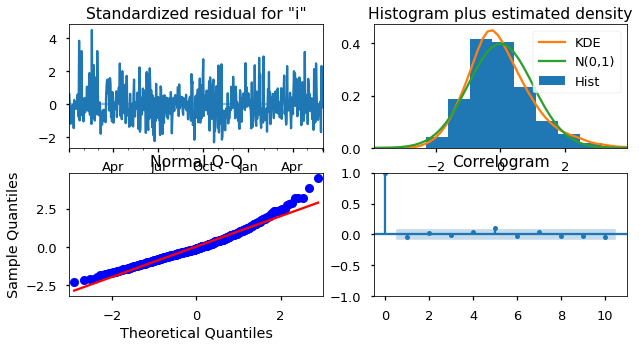

{'summary': <class 'statsmodels.iolib.summary.Summary'>
 """
                                      SARIMAX Results                                     
 Dep. Variable:                       is_canceled   No. Observations:                  519
 Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood                 392.980
 Date:                           Tue, 28 Sep 2021   AIC                           -777.959
 Time:                                   15:02:21   BIC                           -760.960
 Sample:                               01-01-2016   HQIC                          -771.299
                                     - 06-02-2017                                         
 Covariance Type:                             opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 ma.L1         -1.0602      0.019    -57.094      0

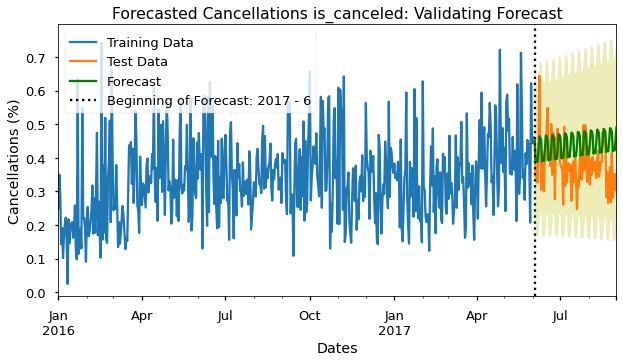

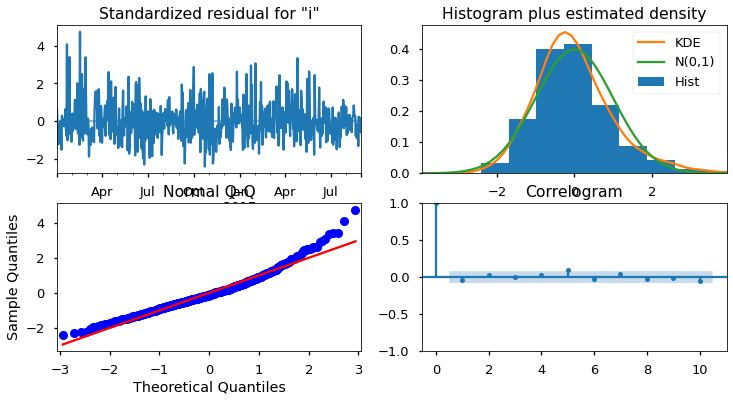

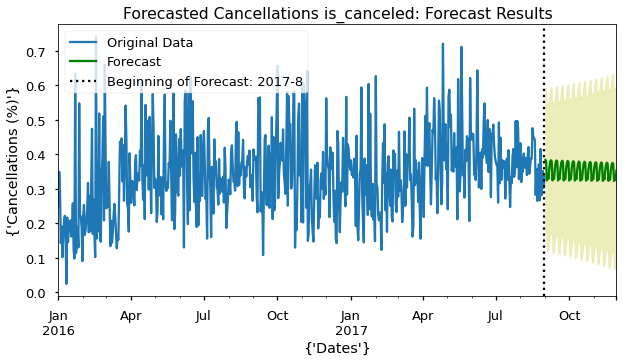

dict_keys(['forecasted_data', 'model', 'forecast_length', 'model_metrics', 'model_visuals'])

In [71]:
results = tsm.ts_modeling_workflow(ts_avg, threshold = -90, xlabel='Dates',
                                   ylabel = 'Cancellations (%)',
                                   title = 'Forecasted Cancellations', m=7,
                                   show_vis=True)

results.keys()

In [67]:
## Reviewing forecasted cancellation percentages
results['forecasted_data']

,Lower CI,Upper CI,Forecast
2017-09-01,0.17,0.59,0.38
2017-09-02,0.17,0.59,0.38
2017-09-03,0.11,0.54,0.32
2017-09-04,0.13,0.55,0.34
2017-09-05,0.12,0.54,0.33
2017-09-06,0.15,0.57,0.36
2017-09-07,0.16,0.59,0.38
2017-09-08,0.17,0.60,0.38
2017-09-09,0.17,0.59,0.38
2017-09-10,0.11,0.54,0.32


In [70]:
## Identifying min/average/max forecasts
forecast_range = [round(results['forecasted_data']['Lower CI'].mean(), 2)*100,
                  round(results['forecasted_data']['Forecast'].mean(), 2)*100,
                  round(results['forecasted_data']['Upper CI'].mean(), 2)*100]
forecast_range

[12.0, 35.0, 59.0]

---

**Forecast Confidence Interval**

> Based on my time series model, the hotels may expect an average 35% cancellations daily. However, there is a confidence interval of  +/- 23.5%.
>
> **This large confidence interval limits the usefulness of the forecast due to the risk of errors.** If a hotel would overbook with the expectation of the average 35% cancellation rate, only to have a 45%+ cancellation rate, it would force the hotel to relocate a large number of reservations. As relocated reservations incur significant costs (both for paying for the relocated night as well as potentially losing future business), the risk of overbooking is too great with this model's forecast.

**Reducing Risk**

> The next step of this analysis would be adjusting the model to reduce variability of the forecast results. The adjustments may include:
 * Adding additional data (holidays, presence/absence of additional demand generators)
 * Adjusting threshold values for train/test split

**Looking Forward**

> My next steps will be to evaluate the impact of shorter- and longer-term thresholds for my training data. Initially, I started with a 90-day evaluation; I will reevaluate the performance using several different thresholds to compare the impact of using different windows for forecasting.

In [110]:
## Testing new thresholds for train/test split and forecast

thresholds = [-3, -7, -15, -30, -60, -90, -180]

ints = {}

for threshold in thresholds:
    results = tsm.ts_modeling_workflow(ts_avg, threshold = threshold, xlabel='Dates',
                                       ylabel = 'Cancellations (%)',
                                       title = 'Forecasted Cancellations',
                                       m=7,show_vis=False)
    
    ints[threshold] = [round(results['forecasted_data']['Lower CI'].mean(), 2)*100,
                  round(results['forecasted_data']['Forecast'].mean(), 2)*100,
                  round(results['forecasted_data']['Upper CI'].mean(), 2)*100]

C:\Users\bmcca\anaconda3\envs\test_intel_env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [134]:
## Combining results into DataFrame for analysis
results_df = pd.DataFrame.from_dict(ints, orient = 'index')
results_df.rename(columns = {0: 'Lower CI', 1: 'Average', 2:'Upper CI'},
                 inplace=True)

results_df['Difference'] = (results_df['Upper CI'] - results_df['Lower CI'])/2

results_df.style.background_gradient(subset = 'Difference', cmap='Reds')

,Lower CI,Average,Upper CI,Difference
-3,15.000000,36.000000,57.000000,21.000000
-7,14.000000,35.000000,57.000000,21.500000
-15,15.000000,36.000000,57.000000,21.000000
-30,13.000000,36.000000,58.000000,22.500000
-60,13.000000,36.000000,59.000000,23.000000
-90,12.000000,35.000000,59.000000,23.500000
-180,8.000000,35.000000,62.000000,27.000000


---

**Interval Impacts**

> Despite changing the threshold levels, there is little improvement in the confidence intervals. 

**In my opinion, the best results came from using a 90-day threshold to forecast cancellations.** 

>The shorter time frames do have smaller confidence intervals, but they also limit the forecast length. Short forecasts are useful for Operations (creating schedules; ordering supplies; etc.), but are little to no use for Sales/Revenue Management teams for selling the hotel rooms.
>
> Additionally, the 90-day window is one of a few standard time frames in my experience. It gives a short-to-medium length perspective to guide decision-making throughout the hotel (versus 3/7/15/30-day windows which are most beneficial to Operations teams).

---

# **Results and Recommendations**

---

**Results and Recommendations**

> 

---